In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
logging.getLogger("cmdstanpy").disabled = True
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import requests



## Introduction

This challenge consists in identifying trends and insights in a sales dataset and forecasting weekly sales based on a time series.

Those were the requirements:
1. Propose recommended actions based on the insights obtained, prioritizing those with the greatest business impact.
2. Model the effects of discounts during holiday weeks.
3. Create an API that allows the store system to query, through an endpoint, the sales forecast for the next four weeks.
4. Predict the sales of each department in each store for the next year.

The solution was implemented with two different models, which will be explained in the following topics, one for the next year prediction and one for the four weeks API:


**Regressor (XGBoost)** - four weeks prediction

**Prophet** - next year prediction



## 1. Propose recommended actions based on the insights obtained, prioritizing those with the greatest business impact.


## 1.1 Data exploration
The dataset consists of 3 csv files containing stores/departments weekly sales from 05/02/2010 to 01/11/2012.

The first step was joining this data to gather all the relevant information and saving it into a new dataset (combined_data.csv)

The code for joining the data can be found in the notebook data_processing.ipynb

In [2]:
#dataframe containing the joined data
df = pd.read_csv('../data/combined_data.csv')
df.head()


,Date,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,week,month,day
0,2010-02-05,1,1,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2,5
1,2010-02-05,29,5,15552.08,False,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,5,2,5
2,2010-02-05,29,6,3200.22,False,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,5,2,5
3,2010-02-05,29,7,10820.05,False,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,5,2,5
4,2010-02-05,29,8,20055.64,False,B,93638,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,5,2,5


### With the combined data it was possible to start visualizing the overall weekly sales trends over the years

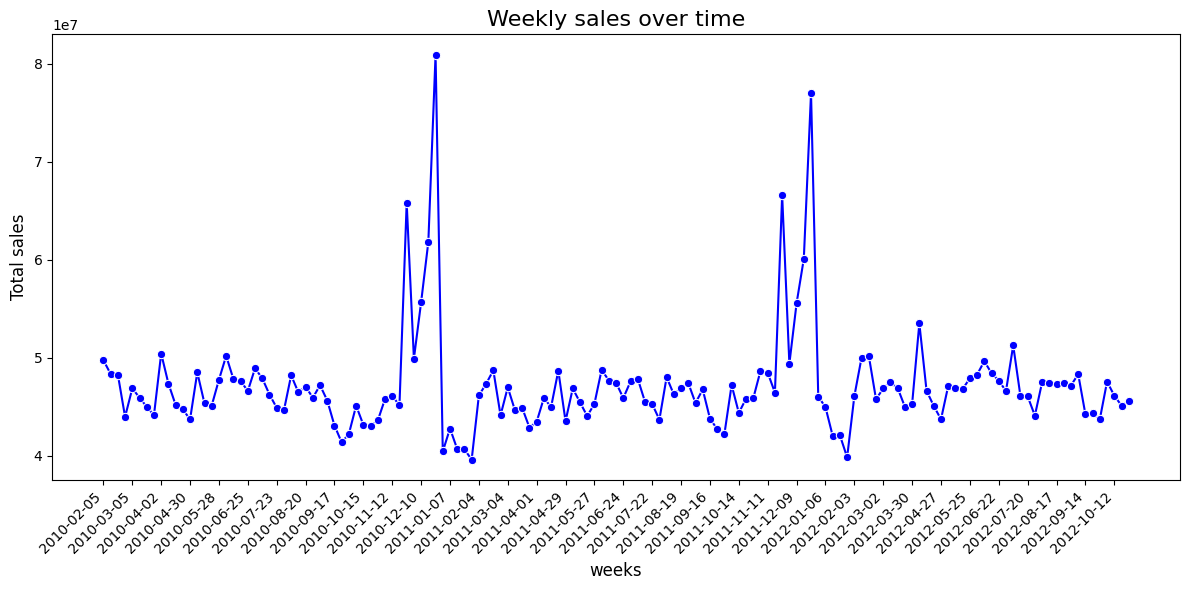

In [3]:
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_sales, x='Date', y='Weekly_Sales', marker='o', color='b')
plt.title('Weekly sales over time', fontsize=16)
plt.xlabel('weeks', fontsize=12)
plt.ylabel('Total sales', fontsize=12)
plt.xticks(weekly_sales.index[::4],  
           weekly_sales['Date'].iloc[::4],
           rotation=45,
           ha='right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

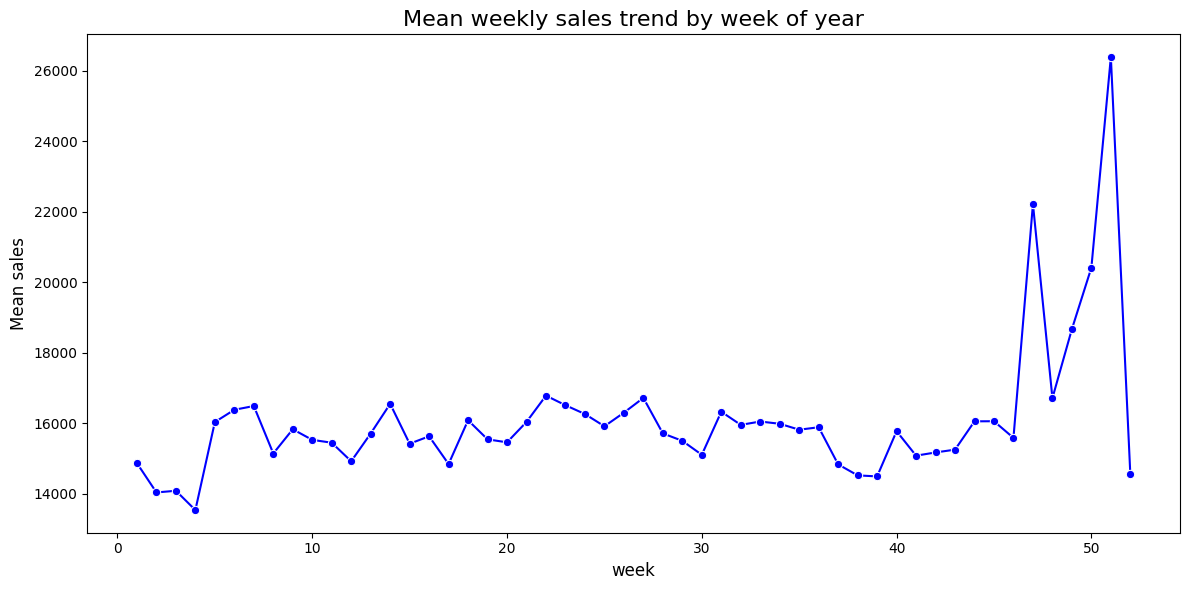

In [4]:
weekly_sales_by_week = df.groupby('week')['Weekly_Sales'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_sales_by_week, x='week', y='Weekly_Sales', marker='o', color='b')
plt.title('Mean weekly sales trend by week of year', fontsize=16)
plt.xlabel('week', fontsize=12)
plt.ylabel('Mean sales', fontsize=12)
plt.tight_layout()
plt.show()

## 1.2 Feature analysis

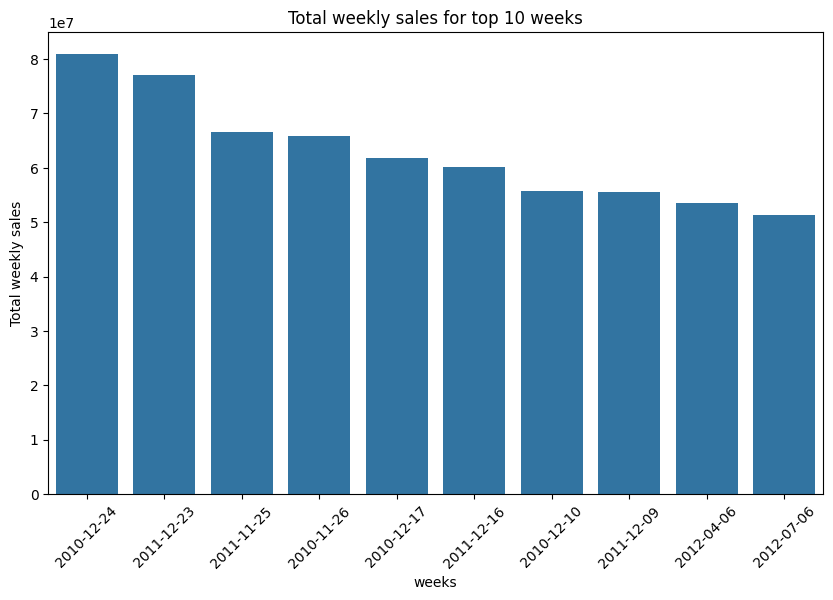

In [5]:
week_sales = df.groupby("Date")["Weekly_Sales"].sum()
top_5_total_sales = week_sales.sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_total_sales.index, y=top_5_total_sales.values)
plt.xlabel("weeks")
plt.ylabel("Total weekly sales")
plt.title("Total weekly sales for top 10 weeks")
plt.xticks(rotation=45)
plt.show()

### The data shows that the highest sales peaks happens on the thanksgiving and christmas weeks, with a drop in the begging of the year, starting to recover on february with the super bowl week 

### The next step was to analyze the influence of external factors (temperature, fuel price, CPI, unemployment) into the weekly sales 

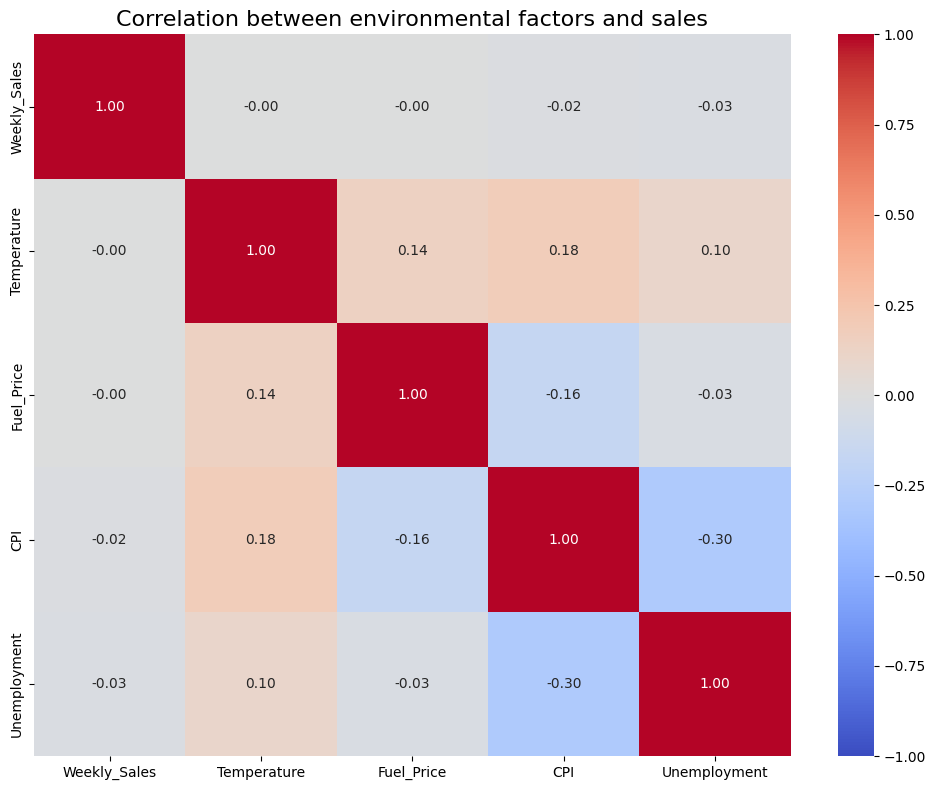

In [6]:
df_corr = df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
correlation_matrix = df_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation between environmental factors and sales', fontsize=16)
plt.tight_layout()
plt.show()

### The data shows that there is almost no correlation between enviroment factores and sales, with unemployment and CPI the only two with a correlation above zero

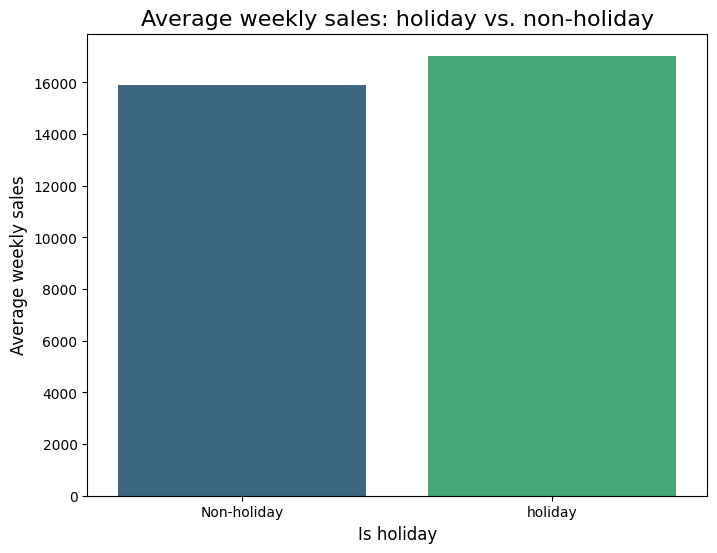

In [7]:
holiday_sales = df.groupby('IsHoliday')['Weekly_Sales'].mean()
plt.figure(figsize=(8, 6))
sns.barplot(x=holiday_sales.index, y=holiday_sales.values, palette='viridis', hue=holiday_sales.index, legend=False)
plt.title('Average weekly sales: holiday vs. non-holiday', fontsize=16)
plt.xlabel('Is holiday', fontsize=12)
plt.ylabel('Average weekly sales', fontsize=12)
plt.xticks([0, 1], labels=['Non-holiday', 'holiday'], fontsize=10)
plt.show()

### Holidays, on the other hand, result in a 6.5% increase on the avarage weekly sales

### Markdowns (discounts) also show a relevant correlation with weekly sales as seen bellow

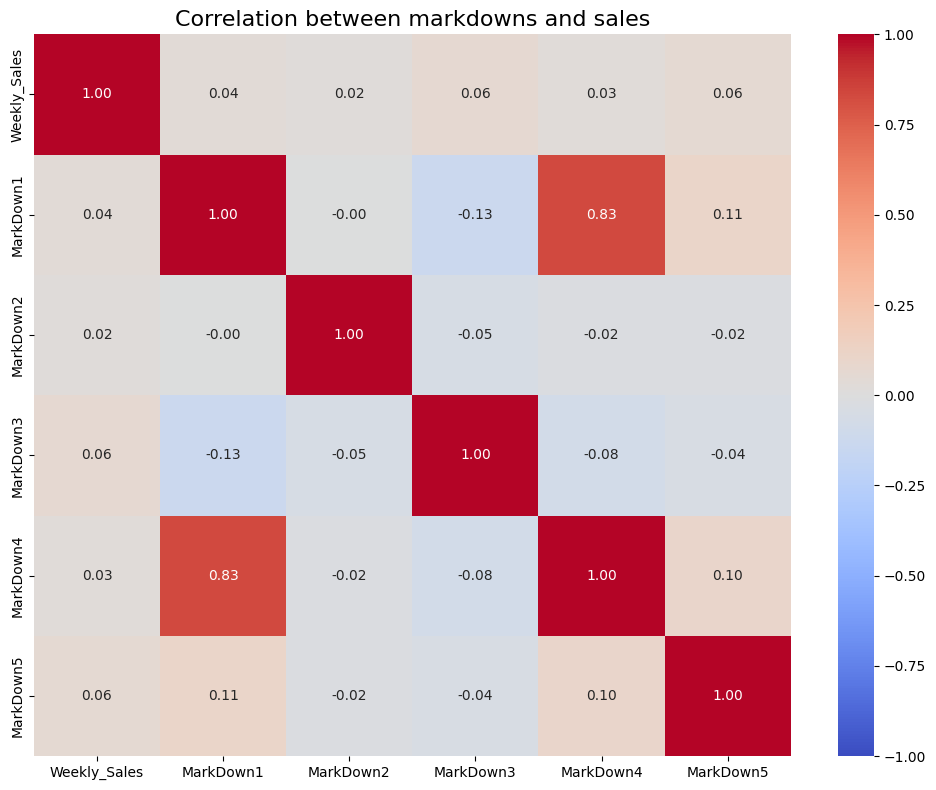

In [8]:
markdown_data = df.dropna()
df_corr = markdown_data[['Weekly_Sales', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']]
correlation_matrix = df_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation between markdowns and sales', fontsize=16)
plt.tight_layout()
plt.show()

### It`s also possible to analyze the relations beetween holidays and Markdowns

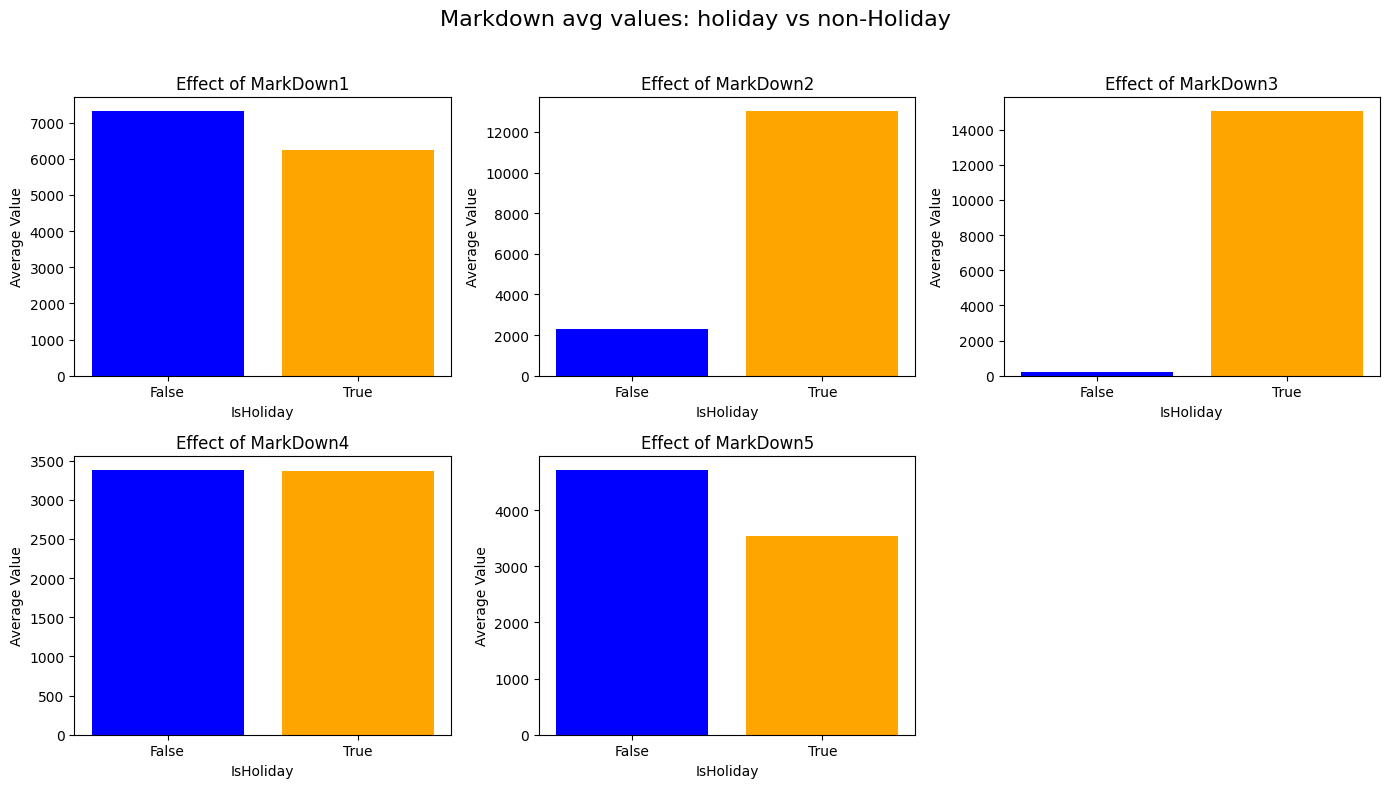

In [9]:
def calc_mean(values):
    return values.mean() if len(values.dropna()) > 0 else 0
markdowns_effect = df.groupby(['IsHoliday']).agg({
    'MarkDown1': calc_mean,
    'MarkDown2': calc_mean,
    'MarkDown3': calc_mean,
    'MarkDown4': calc_mean,
    'MarkDown5': calc_mean,
    'Weekly_Sales': 'mean'
})
markdowns_effect = markdowns_effect.reset_index()
plt.figure(figsize=(14, 8))
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for i, column in enumerate(markdown_columns, 1):
    plt.subplot(2, 3, i)  
    plt.bar(markdowns_effect['IsHoliday'].astype(str), markdowns_effect[column], color=['blue', 'orange'])
    plt.title(f'Effect of {column}')
    plt.ylabel('Average Value')
    plt.xlabel('IsHoliday')
plt.suptitle('Markdown avg values: holiday vs non-Holiday', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Markdown3 and Markdown2 are the ones mostly present only during holidays weeks

### It is also possible to model a regressor using only MarkDown and Store/Dept features 
### The Markdown NaN values were replaced by zero

In [10]:
features = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Store', 'Dept']
X = df[features].fillna(0) 
y = df['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importance:\n", importance)


RMSE: 6374.507898611822
Feature Importance:
 Dept         0.585545
Store        0.356424
MarkDown3    0.026638
MarkDown5    0.012442
MarkDown4    0.007167
MarkDown1    0.006713
MarkDown2    0.005071
dtype: float64


### The model's feature importances show that MarkDown5 and MarkDown3 are the most important MarkDowns to predict a store/dept weekly sales value.

### As seen bellow, those features together with store/department information are enough to create a regressor model that can predict weekly sales really well. The MSE and MAE are relativelly low compared to the avarege weekly sales values, the the R-squared value is close to 1, meaning that the model explains nearly all the variability in the target.

Mean Squared Error (MSE): 40634350.95
Mean Absolute Error (MAE): 2502.95
R-squared (R2): 0.92


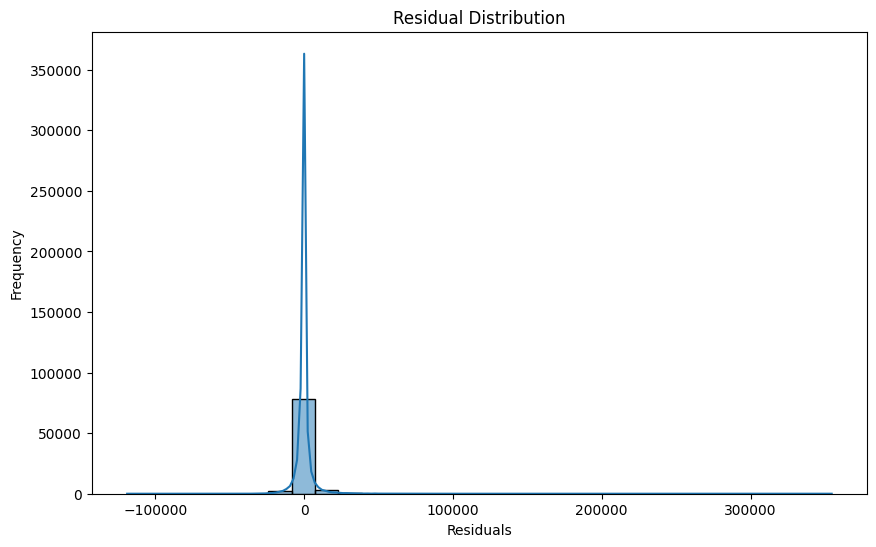

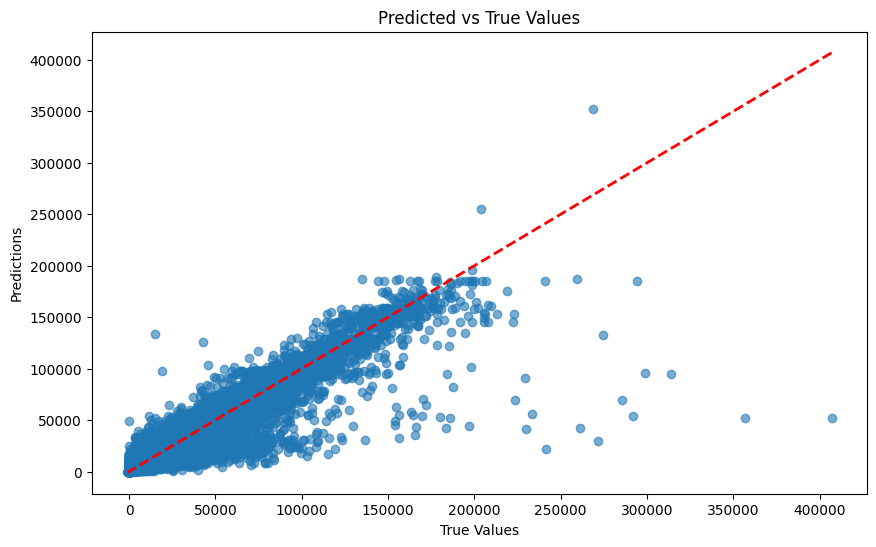

In [11]:
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicted vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


### With SHAP explainer the positive effects of MarkDown3 and MarkDown5 on the weekly sales are clearer

In [12]:
explainer = shap.TreeExplainer(model)
subset = X_test.sample(n=100, random_state=42) 
shap_values = explainer.shap_values(subset)



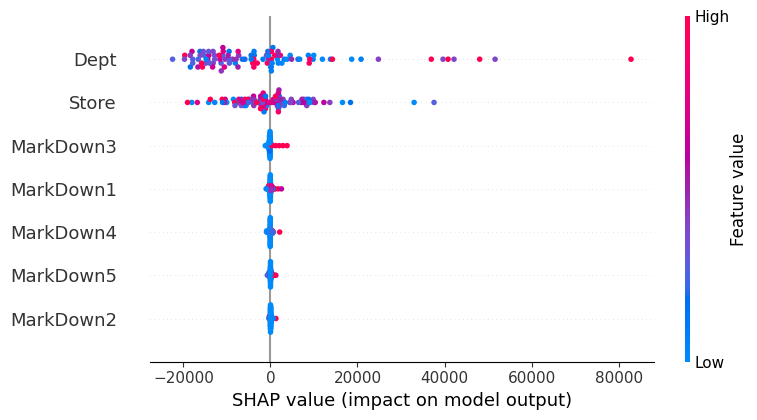

In [13]:
shap.summary_plot(shap_values, subset)
shap.force_plot(explainer.expected_value, shap_values[0], subset.iloc[0])

### Finally we can analyze the weekly sales by store and department

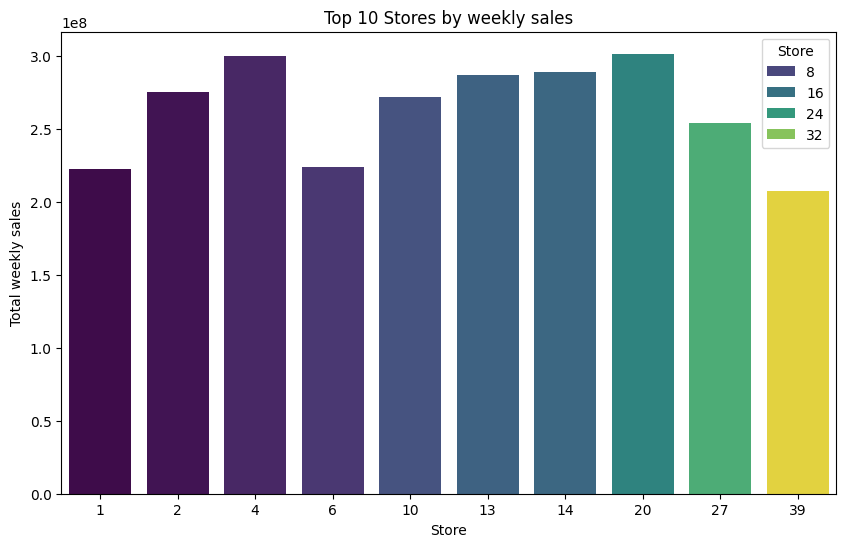

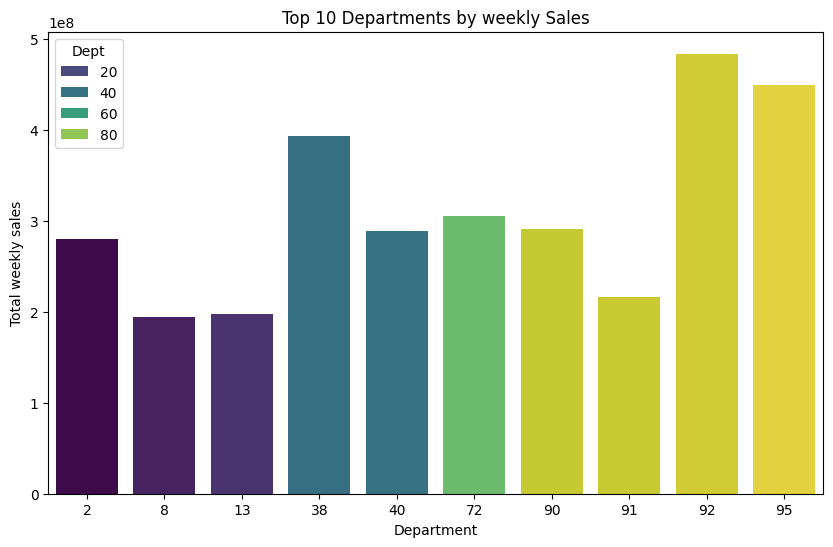

In [14]:
sales_by_store_dept = df.groupby(['Store', 'Dept'])['Weekly_Sales'].sum().reset_index()
sales_by_store_dept = sales_by_store_dept.sort_values(by='Weekly_Sales', ascending=False)
top_stores = sales_by_store_dept.groupby('Store')['Weekly_Sales'].sum().nlargest(10).reset_index()
top_departments = sales_by_store_dept.groupby('Dept')['Weekly_Sales'].sum().nlargest(10).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Store', y='Weekly_Sales', data=top_stores, palette='viridis', hue='Store')
plt.title('Top 10 Stores by weekly sales')
plt.xlabel('Store')
plt.ylabel('Total weekly sales')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Dept', y='Weekly_Sales', data=top_departments, palette='viridis', hue='Dept')
plt.title('Top 10 Departments by weekly Sales')
plt.xlabel('Department')
plt.ylabel('Total weekly sales')
plt.show()

## 1.3 Recommended actions
### Based on the analyzed data, those are my recommended actions:

### - **Optimize markdown strategies**: MarkDowns 3 and 5 are the ones that show the best results for weekly sales creating strategies for the other MarkDows similar to the ones used for 3 and 5 could improve weekly sales
### - **Holiday promotions**: weekly sales are considerably higher during holidays, extending Markdowns strategies to pre and post holiday weeks could improve weekly sales during those periods
### - **Focus on top performing stores**: Analyze what is being done in stores like 20,14 and 4 and reproduce their strategies to low performing stores
### - **Focus on top performing departments**: Analyze what is being done in departments like 92,95 and 38 and reproduce their strategies to low performing departments


## 2. Model the effects of discounts during holiday weeks.


### Modeling those effects will be simillar to the modeling of Markdowns done previously, but now for a subset of only holiday weeks

In [15]:
holiday_data = df[df['IsHoliday']]

features = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Store', 'Dept']
X_holiday = holiday_data[features].fillna(0) 
y_holiday = holiday_data['Weekly_Sales']
X_holiday_train, X_holiday_test, y_holiday_train, y_holiday_test = train_test_split(X_holiday, y_holiday, test_size=0.2, random_state=42)
model_holiday = RandomForestRegressor(random_state=42)
model_holiday.fit(X_holiday_train, y_holiday_train)
y_holiday_pred = model_holiday.predict(X_holiday_test)
rmse = np.sqrt(mean_squared_error(y_holiday_test, y_holiday_pred))
print(f"RMSE: {rmse}")
mse = mean_squared_error(y_holiday_test, y_holiday_pred)
mae = mean_absolute_error(y_holiday_test, y_holiday_pred)
r2 = r2_score(y_holiday_test, y_holiday_pred)
importance = pd.Series(model_holiday.feature_importances_, index=X_holiday.columns).sort_values(ascending=False)
print("Feature Importance:\n", importance)


RMSE: 15492.734884038662
Feature Importance:
 Dept         0.539421
Store        0.287466
MarkDown3    0.113786
MarkDown5    0.020593
MarkDown1    0.014096
MarkDown2    0.012877
MarkDown4    0.011761
dtype: float64


Mean Squared Error (MSE): 240024834.19
Mean Absolute Error (MAE): 4520.94
R-squared (R2): 0.73


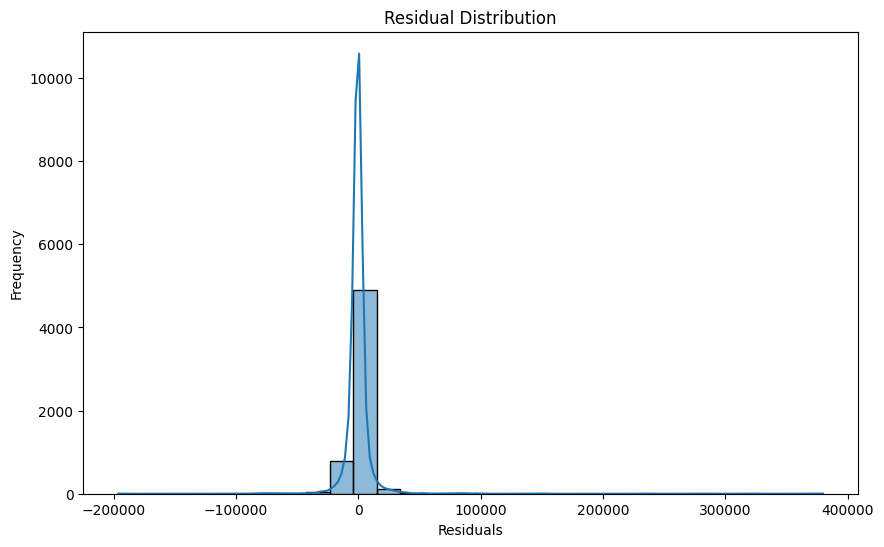

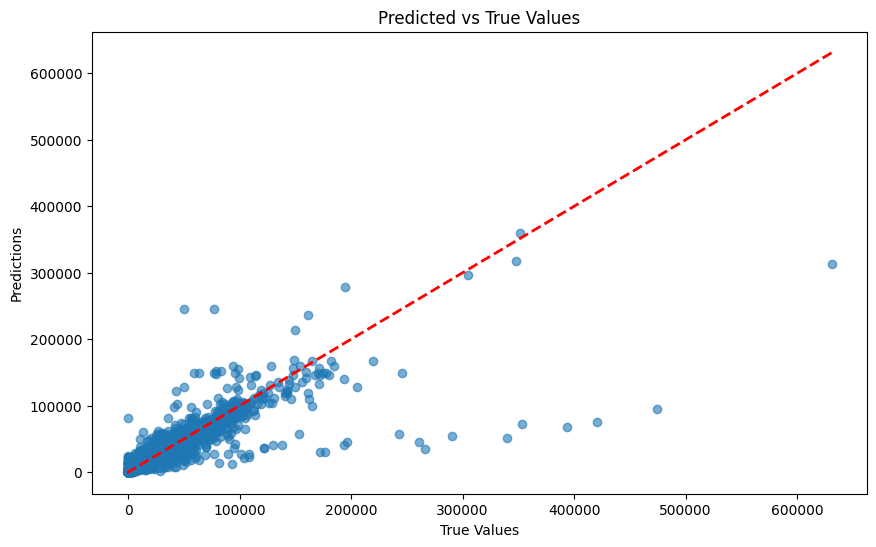

In [16]:
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")
residuals = y_holiday_test - y_holiday_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(10, 6))
plt.scatter(y_holiday_test, y_holiday_pred, alpha=0.6)
plt.plot([y_holiday_test.min(), y_holiday_test.max()], [y_holiday_test.min(), y_holiday_test.max()], 'r--', lw=2)
plt.title('Predicted vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


### The results are similar to before, with MarkDown3 and MarkDown5 having the highest impact in predicting weekly sales
### The R2 is lower and the residuals are worse, but this can be explained by the lower amount of data for holiday weeks

In [17]:
explainer_holiday = shap.TreeExplainer(model_holiday)
subset_holiday = X_holiday_test.sample(n=100, random_state=42) 
shap_values_holiday = explainer_holiday.shap_values(subset_holiday)



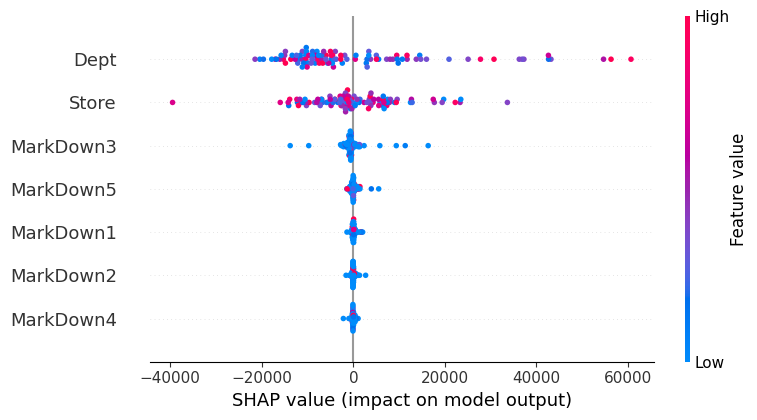

In [18]:
shap.summary_plot(shap_values_holiday, subset)
shap.force_plot(explainer_holiday.expected_value, shap_values[0], subset.iloc[0])

### For MarkDowns 3 2 and 5, increasing their values most of the time results in incresing the model output (weekly sales). For MarkDowns 1 and 4 this is not always true

### This is also shown in the correlation matrix bellow

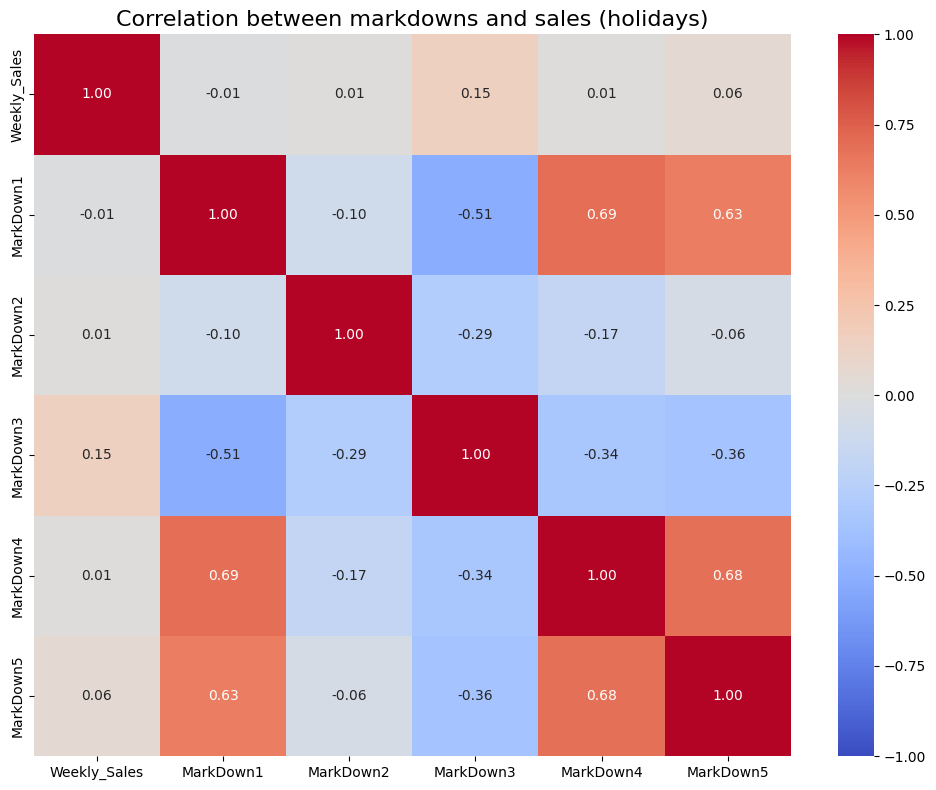

In [19]:
markdown_data = holiday_data.dropna()
df_corr = markdown_data[['Weekly_Sales', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']]
correlation_matrix = df_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation between markdowns and sales (holidays)', fontsize=16)
plt.tight_layout()
plt.show()

## 3. Create an API that allows the store system to query, through an endpoint, the sales forecast for the next four weeks.


## 3.1 Time Series Forecasting
### Time series Forecasting models are special types of predictive models because there is no data available for future predictions.
### Example: In a traditional predictive model (car price prediction) you will train the data with the past data features (color, hp, miles, year, etc), and when predicting a price for a car that was not present in the training data, you will have all those informations to make the new prediction.
### In the time series forecasting models, some information will be present on the training data, but some will not be present on the cases you want to predict.
### Example: For next year the store and department numbers are known, but the temperature, discounts, fuel price, etc, are not known yet.


## 3.2 Feature Engineering
### To overcome this problem it is necessary to create new features called lag features that represent the data from the past (in this case more than 4 weeks in the past) to train the model, so when predicting dates 4 weeks ahead, all the necessary data will be available

In [27]:
#Function used to create the lag features on the data_processing.ipynb notebook
def prepare_forecasting_features_4_weeks(df):
    df = df.copy()
    shiftable_columns = ['Weekly_Sales', 'Temperature', 'MarkDown1', 'Fuel_Price',
                         'MarkDown2', 'MarkDown3', 'MarkDown4', 
                         'MarkDown5', 'CPI', 'Unemployment']
    dropable_columns = ['Temperature', 'MarkDown1', 'Fuel_Price',
                        'MarkDown2', 'MarkDown3', 'MarkDown4', 
                        'MarkDown5', 'CPI', 'Unemployment']
    
    lags = [4, 8, 16, 32]
    for lag in lags:
        for col in shiftable_columns:
            df[f'lag_{lag}_{col}'] = df.groupby(['Store', 'Dept'])[col].shift(lag)
    
    feature_df = df.drop(dropable_columns, axis=1)
    df_clean = feature_df.dropna(subset=['lag_32_Weekly_Sales'])
    return df_clean

## 3.3 Model training
### With the new features a XGBoost regressor model was trained (full training code can be found on 4_weeks_model_training.ipynb)




## 3.4 Results
### Mean Squared Error (MSE): 17788478.90
### Mean Absolute Error (MAE): 1834.73
### R-squared (R2): 0.97

### Residuals:
![Residuals](residuals.png)


### True values vs predictions for X_test (red = true, blue = prediction)
![Pred vs true1](predicted_vs_true.png)
![Pred vs true2](predicted_vs_true_test.png)



### Prediction examples for specific store/depts 
![ex1](example1.png)
![ex2](example2.png)


### Feature explainer
![explained](feature_explained.png)


### The model shows excellent predictive accuracy with minimal error (strong fit to the data (high R²) and small errors in its predictions (low MSE and RMSE))

## 3.5 API and prediction endpoint

### After training and saving the trained model, a class and methods for the model was created on /src/app/model_handler.py

### The API was created using Flask on /src/app/app.py

### The endpoint for making a 4 week prediction can be called by doing a POST request on the route /predict (must run ```python app.py``` first on /src/app)

In [30]:
#Input object consists on know data of the 4 weeks/stores/depts you want to predict
input_obj= {
    'store_data': [
        {
            'Store': 1,
            'Dept': 1,
            'IsHoliday': True,
            'Type': 'A',
            'Size': 1234,
            'date': '28/10/2012'
        },
                {
            'Store': 1,
            'Dept': 1,
            'IsHoliday': False,
            'Type': 'A',
            'Size': 12345,
            'date': '04/11/2011'
        },
                {
            'Store': 1,
            'Dept': 1,
            'IsHoliday': False,
            'Type': 'A',
            'Size': 123456,
            'date': '11/11/2011'
        },
                {
            'Store': 1,
            'Dept': 1,
            'IsHoliday': True,
            'Type': 'A',
            'Size': 123456,
            'date': '18/11/2011'
        },
    ]
}

url = 'http://127.0.0.1:5000/predict'

response = requests.post(url, json=input_obj)

print(response.status_code)
print(response.json())


200
{'prediction': [[30789.775390625], [26289.880859375], [24453.29296875], [23233.81640625]]}


### Each element of the prediction array is a weekly sales prediction for the following weeks (1 to 4)

## 4. Predict the sales of each department in each store for the following year.

### Model
To predict the next year sales it was chosen Facebook's forecasting model [Prophet](https://facebook.github.io/prophet/)

The solution using this model can be found on src/app/prophet_handler.py

In [20]:
import sys
from pathlib import Path
src_path = Path.cwd().parent / "src"
sys.path.append(str(src_path))
from app.prophet_handler import ProphetModel

In [21]:
#Predict returns a dataframe with weekly_sales_prediction for each week of the following year
prophet = ProphetModel()
predictions=prophet.predict(store=1,department=5)
predictions.head(10)

Optimization terminated abnormally. Falling back to Newton.


,date,weekly_sales_prediction,store,department
143,2012-10-28,26206.830604,1,5
144,2012-11-04,27798.298799,1,5
145,2012-11-11,32591.799127,1,5
146,2012-11-18,27299.261546,1,5
147,2012-11-25,29784.966104,1,5
148,2012-12-02,37601.757234,1,5
149,2012-12-09,48551.509625,1,5
150,2012-12-16,56211.993966,1,5
151,2012-12-23,54586.227769,1,5
152,2012-12-30,43259.120392,1,5


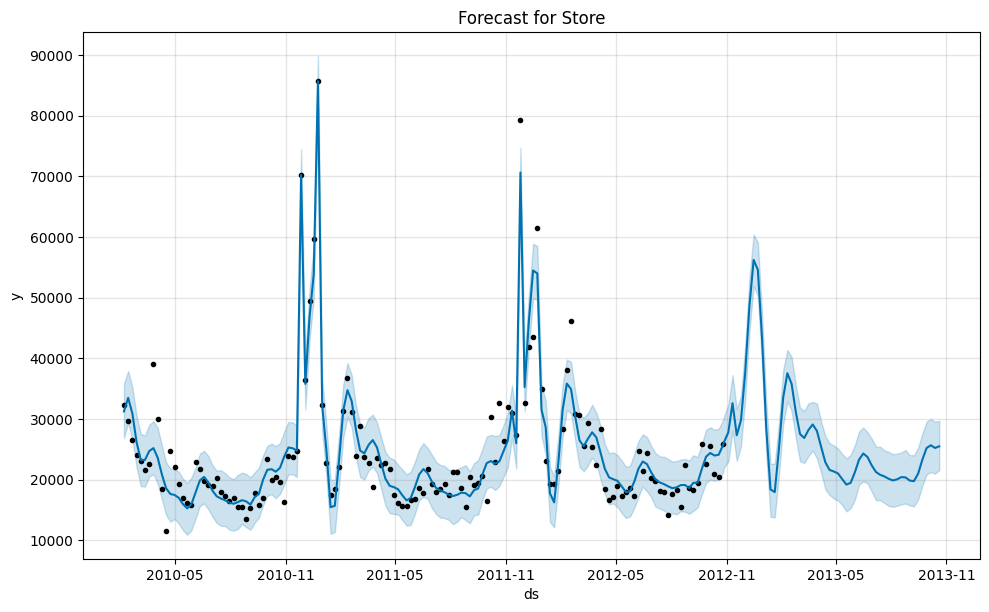

In [22]:
#Plot predictions plot the true values (black dots), and the prediction (blue line)
#y= weekly_sales
#ds = date
prophet.plot_prediction()

Optimization terminated abnormally. Falling back to Newton.


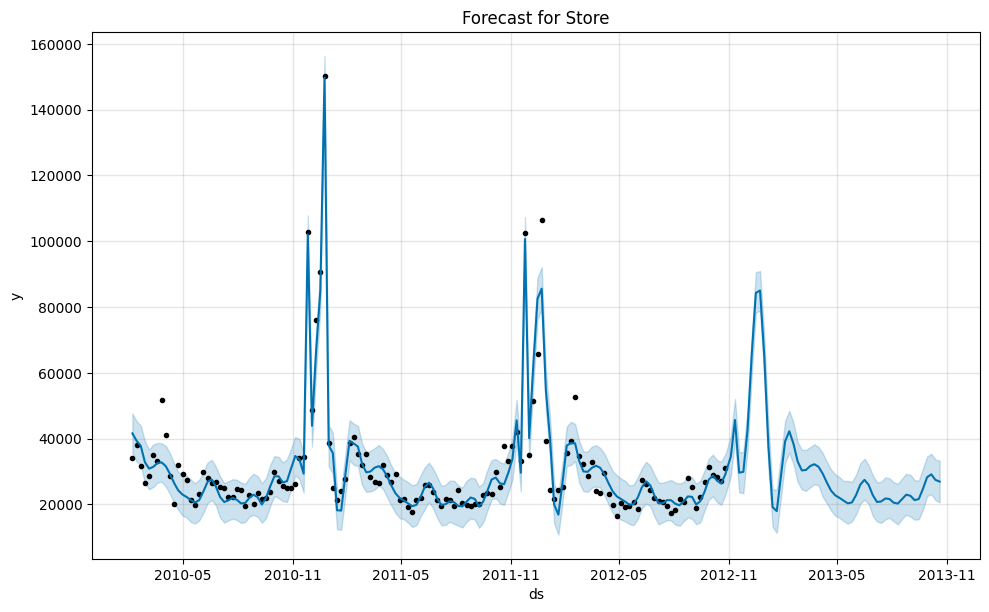

In [23]:
predictions_2=prophet.predict(store=2,department=5)
prophet.plot_prediction()

## Cross validation and performance metrics



In [24]:
performance_df = prophet.performance()


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
100%|██████████| 18/18 [00:46<00:00,  2.57s/it]


In [25]:
performance_df

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,4.481141e+07,6694.132608,4452.050302,0.158392,0.113189,0.152766,0.698925
1,37 days,4.508138e+07,6714.266562,4488.082110,0.160127,0.114614,0.154901,0.677419
2,38 days,4.450724e+07,6671.374921,4506.096767,0.159377,0.118860,0.155436,0.666667
3,39 days,5.179327e+07,7196.753904,4821.634401,0.169510,0.118969,0.164767,0.655914
4,40 days,5.181696e+07,7198.399784,4827.525243,0.169413,0.118969,0.164617,0.652330
...,...,...,...,...,...,...,...,...
325,361 days,2.424428e+07,4923.848565,3798.627171,0.147829,0.136902,0.150276,0.634409
326,362 days,2.395116e+07,4893.992153,3792.416145,0.146836,0.136902,0.151108,0.630824
327,363 days,2.380510e+07,4879.047193,3835.111111,0.150016,0.143034,0.154389,0.623656
328,364 days,2.339443e+07,4836.778554,3781.949916,0.147782,0.140810,0.152330,0.629032
